# Profiling report

This notebook processes the profiling records that were generated by `$REPO_ROOT/profiler.sh`,
computes aggregate statistics
and generates plots to be used for further analysis.

Results are exported to `$REPO_ROOT/reports/nb`.

---

Log

- 23/11/2023: 
    - Updating to multi-actor profiling reports
    - Set global plot config (cfr. `sns.set_context`)

---


In [1]:
import os
import json
import git
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import datetime
from scipy import stats
PARENT_DIR_REPORTS = './reports/nb/'
REPORT_TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
DIR_REPORT = os.path.join(PARENT_DIR_REPORTS, REPORT_TIMESTAMP)
os.makedirs(DIR_REPORT, exist_ok=True)
DIR_REPORT

'./reports/nb/2023-11-23T14:20:57'

Plot config

In [2]:
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":8})   

---

In [3]:
def get_repo_info():    
    repo = git.Repo(path='.')
    return {
        'head': repo.head.commit.__str__(),
        'branch': repo.active_branch.__str__()
    }


## Input data

In [4]:
records = dict(
    map(
        lambda fpath: (fpath, pd.Series(json.loads(open(fpath, 'r').read()), name=fpath)),
        glob('./reports/profiling/*.json')
    )
)
len(records)

200

In [5]:
series = pd.concat(records)
series.index.get_level_values(0).unique().shape
df = series.unstack()
df.index.set_names('fpath',inplace=True)
df.reset_index(inplace=True)
df['actor'] = df.fpath.apply(os.path.basename).str.split('-').apply(lambda x: x[0])
df.index.set_names('idx_report',inplace=True)
df.rename({'start':'start_report','end':'end_report','delta':'delta_report'},axis=1,inplace=True)
display(df.head())
df.shape

,fpath,start_report,end_report,delta_report,records,actor
idx_report,,,,,,
0,./reports/profiling/multiactor-report-17007056...,1700705651846,1700705652864,1018,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
1,./reports/profiling/multiactor-report-17007073...,1700707319196,1700707320396,1200,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
2,./reports/profiling/multiactor-report-17007067...,1700706736010,1700706737210,1200,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
3,./reports/profiling/multiactor-report-17007050...,1700705026999,1700705028072,1073,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor
4,./reports/profiling/multiactor-report-17007033...,1700703315758,1700703316841,1083,"[{'index': 0, 'name': 'createDiplomaCredential...",multiactor


(200, 6)

## Analysis

In [6]:
AGG_FUNCTIONS = ['mean', 'std', 'min','max','count']

---

### Task-level statistics

In [7]:
# Expand report records into task-level dataframes
df_tl = df.records\
    .apply(pd.Series)\
    .stack()\
    .apply(pd.Series)\
    .rename({'index':'idx_step', 'tag': 'actorTag', 'name': 'stepName', },axis=1)\
    .reset_index().drop('level_1',axis=1)\
    .set_index(['idx_report','idx_step'])
# Merge task-level df with initial df
df_tl = df.drop('records',axis=1).merge(df_tl,left_index=True,right_index=True)
df_tl.to_csv(os.path.join(DIR_REPORT, 'df_task-level.csv'))

In [8]:
display(df_tl.head(3))
df_tl.shape

fpath  \
idx_report idx_step                                                      
0          0         ./reports/profiling/multiactor-report-17007056...   
           1         ./reports/profiling/multiactor-report-17007056...   
           2         ./reports/profiling/multiactor-report-17007056...   

                      start_report     end_report delta_report       actor  \
idx_report idx_step                                                          
0          0         1700705651846  1700705652864         1018  multiactor   
           1         1700705651846  1700705652864         1018  multiactor   
           2         1700705651846  1700705652864         1018  multiactor   

                                     stepName          start            end  \
idx_report idx_step                                                           
0          0          createDiplomaCredential  1700705651846  1700705651846   
           1            signDiplomaCredential  1700705651846  1700705652354   
           2         createIdentityCredential  1700705652354  1700705652354   

                     delta    actorTag     className  
idx_report idx_step                                   
0          0             0  university  SolidVCActor  
           1           508  university  SolidVCActor  
           2             0  government  SolidVCActor

(2400, 11)

Compute & export aggregate statistics

In [9]:
# name refers to the function/step name
df_tl_agg = df_tl.groupby(['actorTag','className','stepName'])['delta'].agg(AGG_FUNCTIONS)
df_tl_agg.to_csv(os.path.join(DIR_REPORT, 'df_agg_task-level.csv'))
df_tl_agg.shape

(24, 5)

In [10]:
df_tl_agg.head(3)

mean        std  min  max  \
actorTag className  stepName                                               
alice    DidVCActor createPresentation01       0.14   0.348735    0    1   
                    createPresentation02       0.17   0.377525    0    1   
                    deriveDiplomaCredential  652.25  52.340450  579  936   

                                             count  
actorTag className  stepName                        
alice    DidVCActor createPresentation01       100  
                    createPresentation02       100  
                    deriveDiplomaCredential    100

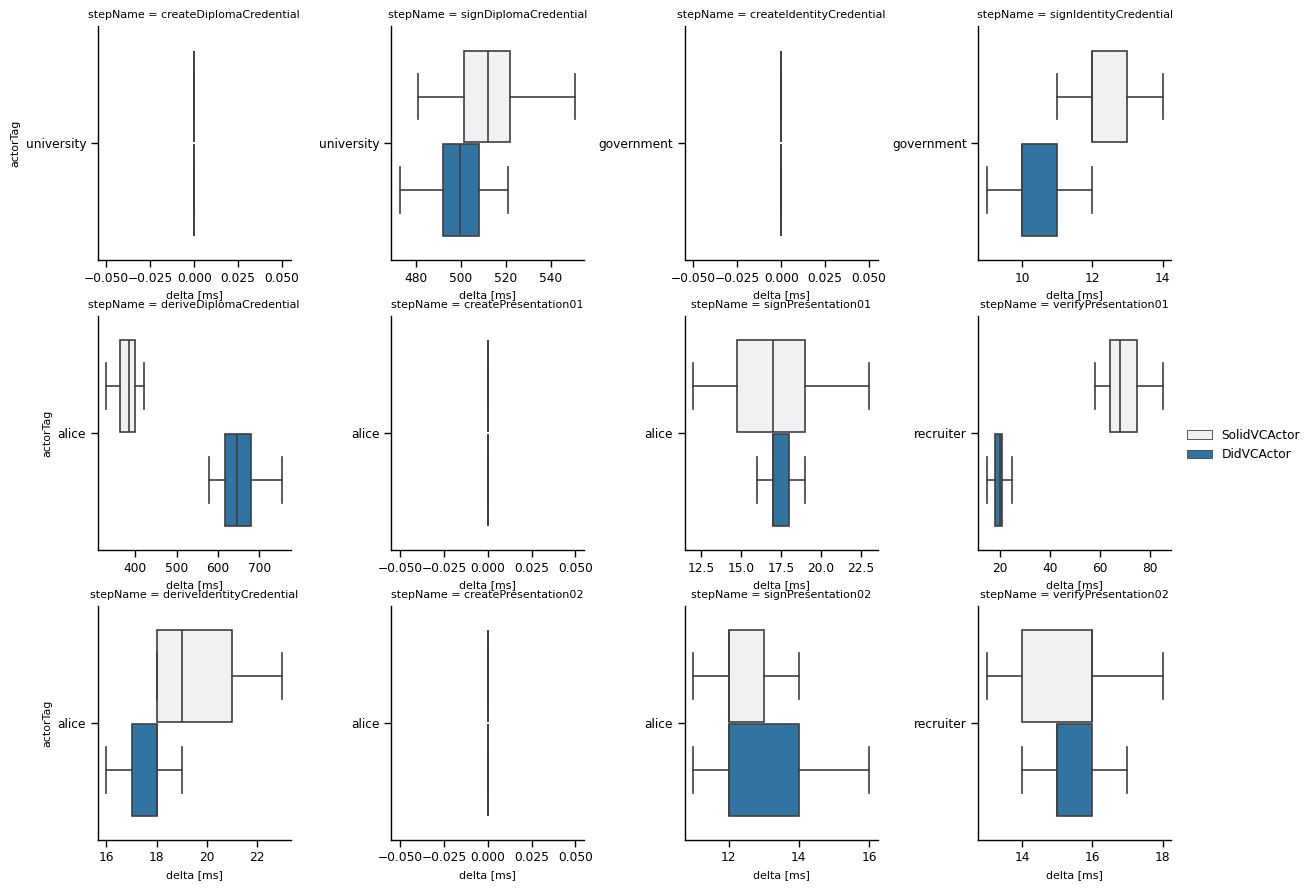

In [11]:
kwargs_fg = dict(col = 'stepName',  col_wrap=4, sharey=False,sharex=False,aspect=1)
kwargs_plot = dict(
    x='delta',
    y='actorTag',
    hue='className',
    orient='h',
    showfliers=False,
)
g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g.map_dataframe(sns.boxplot, **kwargs_plot)

for ax in g.axes.ravel():
    ax.set_xlabel('{} [ms]'.format(kwargs_plot['x']))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    pass
g.add_legend()
plt.savefig(os.path.join(DIR_REPORT,'boxplot-actor-on-delta-per-step.png'),pad_inches=.5)
plt.show()

In [12]:
# df_stepname_order is used to specify the order in which the facetgrid must create the plots
df_stepname_order = df_tl.reset_index()[['idx_step','stepName','actorTag']].drop_duplicates()
df_stepname_order

,idx_step,stepName,actorTag
0,0,createDiplomaCredential,university
1,1,signDiplomaCredential,university
2,2,createIdentityCredential,government
3,3,signIdentityCredential,government
4,4,deriveDiplomaCredential,alice
5,5,createPresentation01,alice
6,6,signPresentation01,alice
7,7,verifyPresentation01,recruiter
8,8,deriveIdentityCredential,alice
9,9,createPresentation02,alice


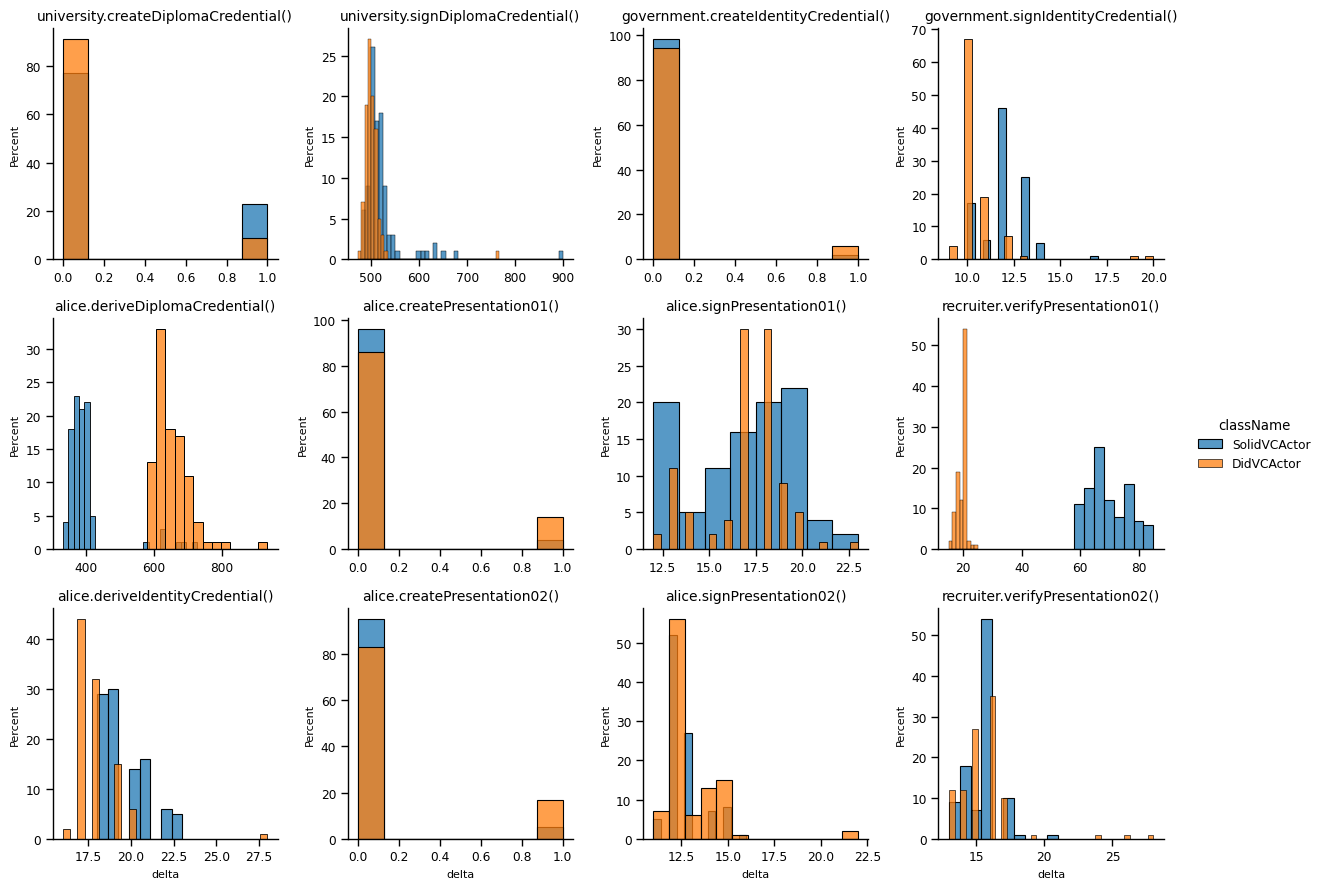

In [13]:
kwargs_fg = dict(col = 'stepName',
                 hue='className',
                 col_wrap=4,
                 sharey=False,
                 sharex=False,
                 legend_out=True,
                 col_order = df_stepname_order['stepName']
)
kwargs_plot = dict(
    x='delta',
    stat='percent',
    element='bars',
    discrete=False,
)

g = sns.FacetGrid(**kwargs_fg, data=df_tl)
g = g.map_dataframe(sns.histplot, **kwargs_plot)
for ax in g.axes.ravel():
    pass

for i, r in df_stepname_order.iterrows():
    ax_i = g.axes_dict[r.stepName]
    ax_i.set_title(f'{r.actorTag}.{r.stepName}()')


g.add_legend()
g.tight_layout()
plt.savefig(os.path.join(DIR_REPORT,'barplot-actor-on-percentage-delta-per-step.png'))
plt.show()

In [14]:
get_repo_info()
json.dump(get_repo_info(), open(os.path.join(DIR_REPORT,'repo-info.json'), 'w'))

---

ALL CELLS BELOW NEED TO UPDATED.</br>
The profiling data model changed while transitioning to multiactor profiling :) .

---

## Statistics

### Significance testing

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [15]:
p_thresh = .05

In [16]:
steps = df_tl.stepName.unique()
print(steps)

['createDiplomaCredential' 'signDiplomaCredential'
 'createIdentityCredential' 'signIdentityCredential'
 'deriveDiplomaCredential' 'createPresentation01' 'signPresentation01'
 'verifyPresentation01' 'deriveIdentityCredential' 'createPresentation02'
 'signPresentation02' 'verifyPresentation02']


In [17]:
grpr_className = df_tl.groupby('className')
assert grpr_className.ngroups == 2
A,B = grpr_className

Reminder

- H0: There is no significant difference in performance between the two software implementations.
- H1: There is a significant difference in performance between the two software implementations.

In [18]:
_var = 'delta'
ttr_ind_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

print(f'''
    Group A: {k_a}
    Group B: {k_b}
    Tested variable: {_var}
''')
for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var].values.tolist()
        b = df_b[df_b.stepName == step_name][_var].values.tolist()
        assert np.shape(a) == np.shape(b)
        ttr_ind_per_step[step_name]=stats.ttest_ind(a,b)
        
df_test_results = pd.Series(ttr_ind_per_step).apply(lambda t: t._asdict()).apply(pd.Series)
df_test_results.rename({'statistic': 'tvalue'}, axis=1,inplace=True)
# Add flag to indicate whether to accept/reject H0
df_test_results['REJECT_H0'] = df_test_results.pvalue < p_thresh
df_test_results['Conclusion'] = df_test_results.REJECT_H0.apply(lambda reject_H0: 
                                                                f'Significant difference in "{_var}" between {k_a} and {k_b}' if reject_H0
                                                                else f'No significant difference in "{_var}" between {k_a} and {k_b}' 
                                                               )
df_test_results


    Group A: DidVCActor
    Group B: SolidVCActor
    Tested variable: delta



,tvalue,pvalue,df,_alternative,_standard_error,_estimate,REJECT_H0,Conclusion
createDiplomaCredential,-2.737132,6.761936e-03,198.0,0.0,0.051148,-0.14,True,"Significant difference in ""delta"" between DidV..."
signDiplomaCredential,-3.455006,6.731413e-04,198.0,0.0,5.881322,-20.32,True,"Significant difference in ""delta"" between DidV..."
createIdentityCredential,1.443680,1.504095e-01,198.0,0.0,0.027707,0.04,False,"No significant difference in ""delta"" between D..."
signIdentityCredential,-7.824610,2.989475e-13,198.0,0.0,0.190425,-1.49,True,"Significant difference in ""delta"" between DidV..."
deriveDiplomaCredential,28.343492,1.294387e-71,198.0,0.0,8.972783,254.32,True,"Significant difference in ""delta"" between DidV..."
createPresentation01,2.496849,1.334581e-02,198.0,0.0,0.040050,0.10,True,"Significant difference in ""delta"" between DidV..."
signPresentation01,0.295484,7.679338e-01,198.0,0.0,0.338428,0.10,False,"No significant difference in ""delta"" between D..."
verifyPresentation01,-71.315470,3.619491e-143,198.0,0.0,0.703634,-50.18,True,"Significant difference in ""delta"" between DidV..."
deriveIdentityCredential,-8.252827,2.146932e-14,198.0,0.0,0.201143,-1.66,True,"Significant difference in ""delta"" between DidV..."
createPresentation02,2.749337,6.524234e-03,198.0,0.0,0.043647,0.12,True,"Significant difference in ""delta"" between DidV..."


In [19]:
steps_with_sig_diff = df_test_results[df_test_results.REJECT_H0].index
print(steps_with_sig_diff)

Index(['createDiplomaCredential', 'signDiplomaCredential',
       'signIdentityCredential', 'deriveDiplomaCredential',
       'createPresentation01', 'verifyPresentation01',
       'deriveIdentityCredential', 'createPresentation02'],
      dtype='object')


In [20]:
df_tl_sig_diff = df_tl[df_tl.stepName.apply(lambda n: n in steps_with_sig_diff)]
df_tl_sig_diff.shape

(1600, 11)

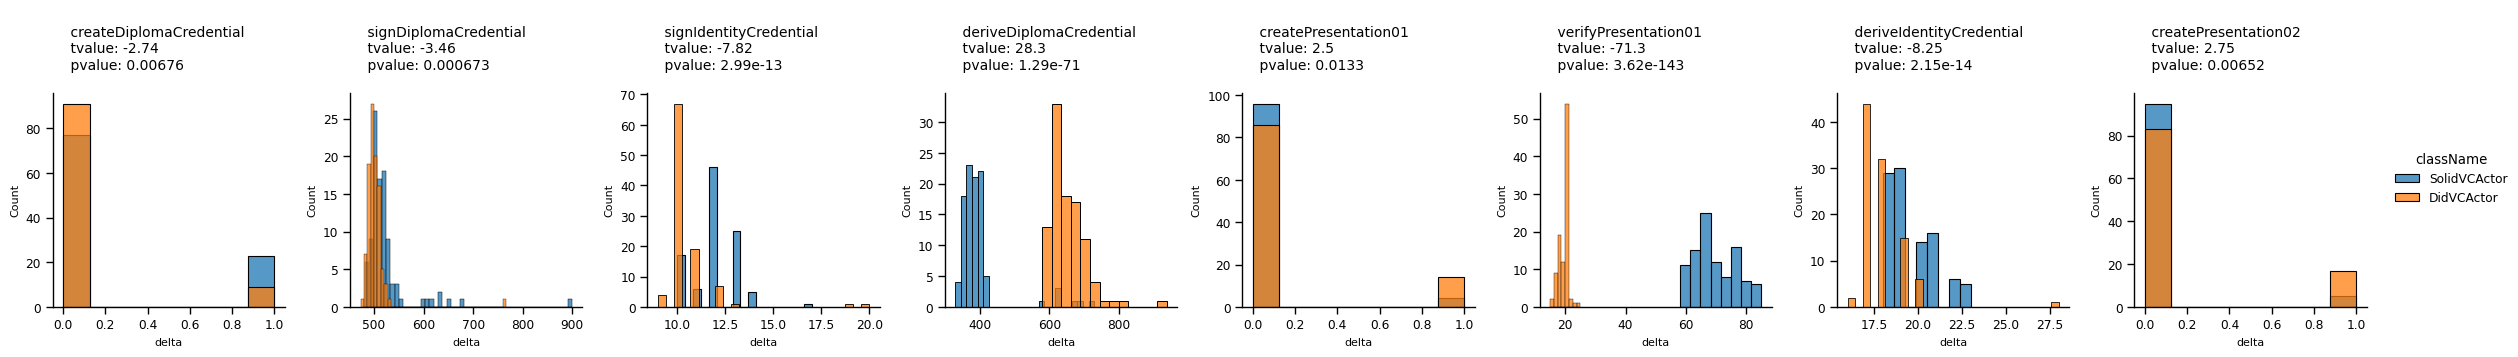

In [21]:
g = sns.FacetGrid(df_tl_sig_diff,col='stepName',legend_out=True, hue='className',sharex=False, sharey=False)

g = g.map_dataframe(sns.histplot, x='delta',)
g.add_legend()

for c in g.col_names:
    s = df_test_results.loc[c]

    g.axes_dict[c].set_title('',loc='center')
    txt_stats = f'''
    {c}
    tvalue: {s["tvalue"]:.3}
    pvalue: {s["pvalue"]:.3}
    '''
    g.axes_dict[c].set_title(txt_stats,loc='left')

### Effect size

#### Cohen's d

$$
d = \frac{\bar x_1 - \bar x_2}{s}
$$

|Effect size|	d|
|-----------|----|
|Very small	|0.01|
|Small		|0.20|
|Medium		|0.50|
|Large		|0.80|
|Very large	|1.20|
|Huge		|2.00|


> A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. In terms of size, Cohen suggested that a d of 0.2 represents a small effect, 0.5 a medium effect, and 0.8 or higher a large effect. However, these are guidelines rather than strict rules.

In [22]:
from numpy import var, mean, sqrt

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)

    # return the effect size
    return (u1 - u2) / s

In [23]:
_var = 'delta'
effect_size_per_step = {}
# destructure group key and group dfs
k_a, df_a = A
k_b, df_b = B

for step_name in steps:
        a = df_a[df_a.stepName == step_name][_var]
        b = df_b[df_b.stepName == step_name][_var]
        effect_size_per_step[step_name] = cohend(a,b)
        
s_effect_sizes = pd.Series(effect_size_per_step, name=f'cohend_{k_a}_{k_b}')

df_effect_sizes = s_effect_sizes.to_frame()
def cohend_effect_class(d: float) -> str:
    d = np.abs(d)
    if d >= 2.0:
        return 'HUGE'
    if d >= 1.2:
        return 'VERY_LARGE'
    if d >= 0.8:
        return 'LARGE'
    if d >= 0.5:
        return 'MEDIUM'
    if d >= 0.2:
        return 'SMALL'
    if d > 0.01:
        return 'VERY_SMALL'
    return 'NIHIL'

df_effect_sizes['effect_class'] = s_effect_sizes.apply(cohend_effect_class)
df_effect_sizes

,cohend_DidVCActor_SolidVCActor,effect_class
createDiplomaCredential,-0.387089,SMALL
signDiplomaCredential,-0.488612,SMALL
createIdentityCredential,0.204167,SMALL
signIdentityCredential,-1.106567,LARGE
deriveDiplomaCredential,4.008375,HUGE
createPresentation01,0.353108,SMALL
signPresentation01,0.041788,VERY_SMALL
verifyPresentation01,-10.085531,HUGE
deriveIdentityCredential,-1.167126,LARGE
createPresentation02,0.388815,SMALL


In [24]:
df_effect_sizes.to_csv(os.path.join(DIR_REPORT, 'df_effect_sizes.csv'))

# Appendix

## Statsmodels

In [25]:
?stats.ttest_ind

Signature:
stats.ttest_ind(
    a,
    b,
    axis=0,
    equal_var=True,
    nan_policy='propagate',
    permutations=None,
    random_state=None,
    alternative='two-sided',
    trim=0,
    *,
    keepdims=False,
)
Docstring:
Calculate the T-test for the means of *two independent* samples of scores.

This is a test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

Parameters
----------
a, b : array_like
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
axis : int or None, default: 0
    If an int, the axis of the input along which to compute the statistic.
    The statistic of each axis-slice (e.g. row) of the input will appear in a
    corresponding element of the output.
    If ``None``, the input will be raveled before computing the statistic.
equal_var : bool, optional
    If True (default), pe